In [1]:
import os

# Suppress oneDNN optimizations and lower TensorFlow logging level
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Load Data set
(X_train, _), (X_test, _) = mnist.load_data()

# Normalize the pixel values
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

# Expand dimensions to match the input shape (28, 28, 1)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Add noise to the data
noise_factor = 0.5
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0, scale=1., size=X_train.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0, scale=1., size=X_test.shape)

# Clip the values to be within the range [0, 1]
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

### Build the diffusion model

In [4]:
input_layer = Input(shape=(28, 28, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer) # Reduced filters
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x) # Reduced filters
x = Flatten()(x)
x = Dense(64, activation='relu')(x) # Reduced size
x = Dense(28*28*32, activation='relu')(x) # Reduced size
x = Reshape((28, 28, 32))(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x) # Reduced filters
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x) # Reduced filters
output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x) # Output
diffusion_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with mixed precision and a different loss function
diffusion_model.compile(optimizer='adam', loss='mean_squared_error') # Using MSE for regression tasks

diffusion_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25088)          │     1,630,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 28, 28, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,255,233 (12.42 MB)

 Trainable params: 3,255,233 (12.42 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_noisy, X_train))
train_dataset = train_dataset.cache().batch(64).prefetch(tf.data.AUTOTUNE) # Reduced batch size

val_dataset = tf.data.Dataset.from_tensor_slices((X_test_noisy, X_test))
val_dataset = val_dataset.cache().batch(64).prefetch(tf.data.AUTOTUNE) # Reduced batch size

In [6]:
# Implement early stopping based on validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with early stopping and smaller batch size
diffusion_model.fit(
    train_dataset,
    epochs=3,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 78s 81ms/step - loss: 0.0664 - val_loss: 0.0290
Epoch 2/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 78s 83ms/step - loss: 0.0268 - val_loss: 0.0278
Epoch 3/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 82s 87ms/step - loss: 0.0235 - val_loss: 0.0254


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


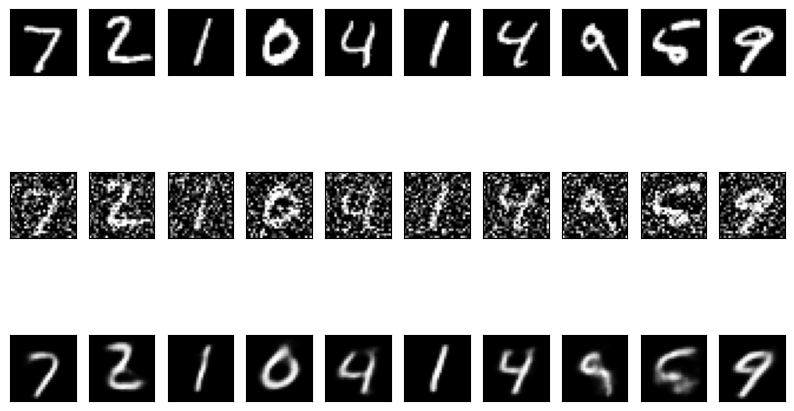

In [7]:
import matplotlib.pyplot as plt

# Predict the denoised images
denoised_images = diffusion_model.predict(X_test_noisy)

# Visualize the results
n = 10 # Number of digits to display
plt.figure(figsize=(10, 6))
for i in range(n):
    # Display Original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(X_test_noisy[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()